In [26]:
# user defined functions

import odor_statistics_lib as osm

# dataframes
import pandas as pd
import h5py

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import signal
from scipy import stats
from scipy.signal import butter, filtfilt
from pykalman import KalmanFilter
import pingouin as pg
from scipy import fft

#plots
import string
import figurefirst
from figurefirst import FigureLayout,mpl_functions
import matplotlib.ticker as mtick
import pylab as plt
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns
sns.set()
sns.set_style("whitegrid")
pd.options.mode.chained_assignment = None

In [3]:
dir = '~/DataAnalysis/data/Sprints/HighRes/'

In [4]:
df1 = pd.read_hdf(dir+'Windy/WindyMASigned.h5')
df2 = pd.read_hdf(dir+'NotWindy/NotWindyMASigned.h5')
df3 = pd.read_hdf(dir+'Forest/ForestMASigned.h5')

In [5]:
df=pd.concat([df1,df2,df3])
df.reset_index(inplace=True, drop=True)

### Ground Speed Histogram

In [11]:
## GROUND SPEED CALCULATION

# def project(a,b):
#     return (np.dot(a, b) / np.dot(b, b)) * b

# new_ground_speed=[]
# for i in range(len(df)):
#     wind= np.array([df.corrected_u[i],df.corrected_v[i]])
#     gps=np.array([df.gps_linear_x[i],df.gps_linear_y[i]])
#     new_ground_speed.append(project(gps,wind))
    
# ngs=np.vstack(new_ground_speed)
# df['ground_speed_x']=ngs[:,0]
# df['ground_speed_y']=ngs[:,1]

/tmp/ipykernel_349283/2036922753.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar1 = plt.colorbar(hist1[3], ax=ax[0])
/tmp/ipykernel_349283/2036922753.py:18: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar2 = plt.colorbar(hist2[3], ax=ax[1])
/tmp/ipykernel_349283/2036922753.py:25: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar3 = plt.colorbar(hist3[3], ax=ax[2])


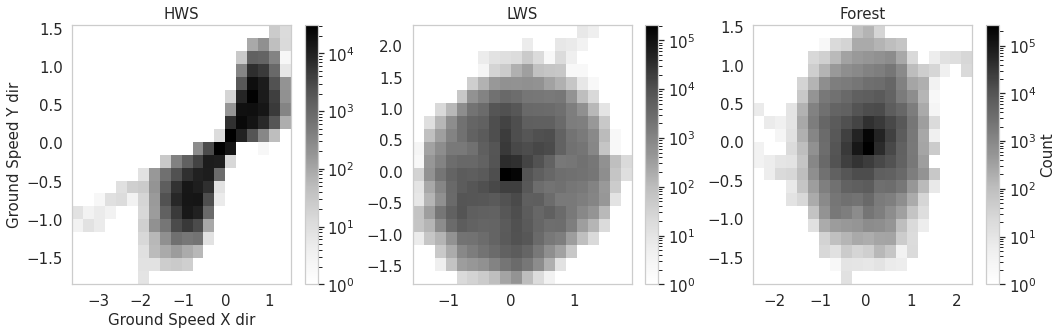

In [10]:
f, ax = plt.subplots(1, 3, figsize=(15, 5))
# Loop over each subplot
for subplot_ax in ax:
    subplot_ax.grid(False)
# First subplot
hist1 = ax[0].hist2d(df1.ground_speed_x, df1.ground_speed_y,
                     cmap='Greys', bins=20, norm=colors.LogNorm(), rasterized=True)

cbar1 = plt.colorbar(hist1[3], ax=ax[0])
ax[0].set_title('HWS')

ax[0].set_xlabel('Ground Speed X dir')
ax[0].set_ylabel('Ground Speed Y dir')

# Second subplot
hist2 = ax[1].hist2d(df2.ground_speed_x, df2.ground_speed_y,
                     cmap='Greys', bins=20, norm=colors.LogNorm(), rasterized=True)
cbar2 = plt.colorbar(hist2[3], ax=ax[1])
ax[1].set_title('LWS')


# Third subplot
hist3 = ax[2].hist2d(df3.ground_speed_x, df3.ground_speed_y,
                     cmap='Greys', bins=20, norm=colors.LogNorm(), rasterized=True)
cbar3 = plt.colorbar(hist3[3], ax=ax[2])
cbar3.set_label('Count')

ax[2].set_title('Forest')

f.tight_layout(pad=2)

figurefirst.mpl_functions.set_fontsize(f, 15)
# f.savefig('../../Figure/hist_gs.jpeg', dpi=300, bbox_inches = "tight")

### Power spectra of direction of movement



In [12]:
## Direction of movement Calculation


# Calculate the direction of movement in radians
direction_of_movement_radians_windy = np.arctan2(df1.ground_speed_y, df1.ground_speed_x)

In [17]:
power_spectrum = np.abs(np.fft.fft(direction_of_movement_radians_windy))**2
# Calculate the frequencies associated with each power spectrum bin
frequencies = np.fft.fftfreq(len(direction_of_movement_radians_windy))


/tmp/ipykernel_349283/133799782.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(frequencies), np.log10(power_spectrum))
/tmp/ipykernel_349283/133799782.py:2: RuntimeWarning: invalid value encountered in log10
  plt.plot(np.log10(frequencies), np.log10(power_spectrum))


Text(0.5, 1.0, 'Power Spectrum of Direction')

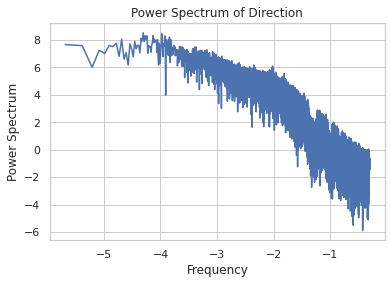

In [21]:
# Plot the power spectrum
plt.plot(np.log10(frequencies), np.log10(power_spectrum))
plt.xlabel('Frequency')
plt.ylabel('Power Spectrum')
plt.title('Power Spectrum of Direction')
# plt.xlim(0,0.001)

In [23]:
def fft_of_data(data,dt):
    data = data-np.mean(data)
    N = data.shape[0] # Length of data.
    try:
        yf = 2.0/N * np.abs(fft.fft(data)[0:N//2])# Divide to bring the magnitude to the magnitude of the orginal sinewave.
    except ZeroDivisionError:
        yf= 0
    # Remember the the y-data will be complex so you have to take the absolute value.
    xf = fft.fftfreq(N,dt)[:N//2]# Only take the first half of the data.
    return(xf, yf) # xf = frequency array. yf = amplitude or power.

def segment_data(df, column_title, lower_lim, upper_lim):
    q = column_title + ' < ' + str(upper_lim) + ' and ' + column_title + ' > ' + str(lower_lim)
    new_df = df.query(q)
    return(new_df)

/tmp/ipykernel_349283/4205416284.py:9: RuntimeWarning: divide by zero encountered in log10
  ax.plot(np.log10(xf), np.log10(yf), label='Desert Wind Speed > 3m/s')


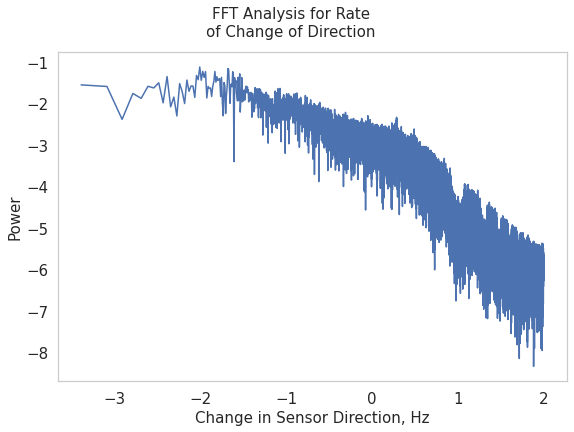

In [30]:
amp = []
freq = []
dt=df1.master_time[1]-df1.master_time[0]
xf,yf = fft_of_data(np.array(direction_of_movement_radians_windy),dt)
f,ax = plt.subplots(1,1, figsize=(8,6))

# ax.axvspan(-3.5, -1,  alpha=0.2)
# ax.axvline(1, color='r')
ax.plot(np.log10(xf), np.log10(yf), label='Desert Wind Speed > 3m/s')
# ax.plot(np.log10(xf1), np.log10(yf1), label='Desert Wind Speed > 3m/s', alpha=0.6)
# ax.plot(np.log10(xf2), np.log10(yf2), label='Forest', alpha=0.4)
ax.set_xlabel('Change in Sensor Direction, Hz')
ax.set_ylabel('Power')
ax.grid(False)



# mpl_functions.adjust_spines(ax,['left', 'bottom'],spine_locations={},
#                             smart_bounds=True, xticks=[-4,-1,2],yticks=[-7,-3.5,0],linewidth=1)
# ax.set_xticklabels([r'$10^{-4}$',r'$10^{-1}$', r'$10^{2}$'])
# ax.set_yticklabels([r'$10^{-7}$',r'$10^{-3.5}$', r'$10^{0}$'])

f.suptitle('FFT Analysis for Rate\nof Change of Direction')
f.tight_layout(pad=1)
figurefirst.mpl_functions.set_fontsize(f, 15)

# leg = ax.legend(loc='lower left', fontsize=16)
# for lh in leg.legendHandles: 
#     lh.set_alpha(1)

# f.savefig('../../Figure/Plots/FFT_1.jpeg', dpi=300, bbox_inches = "tight")

### Distribution of where we walked relative to the source

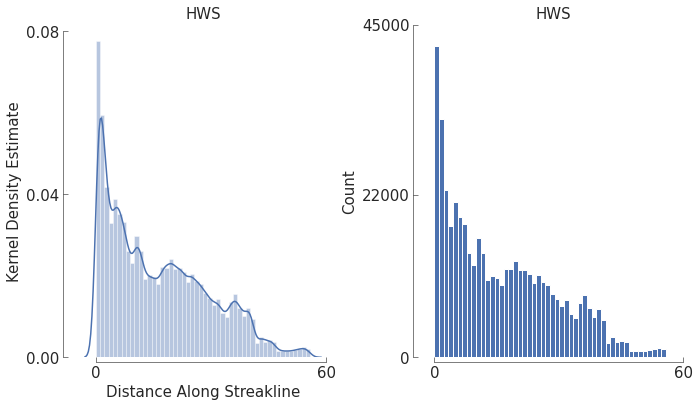

In [71]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(10,6))
sns.distplot(df1.distance_from_source_a*df1.xsign, bins=50, kde=True, norm_hist=True, ax=ax1)
ax1.set_xlabel('Distance Along Streakline')
ax1.set_ylabel('Kernel Density Estimate')
ax1.grid(False)

ax1.set_title('HWS')
mpl_functions.adjust_spines(ax1,['left','bottom'],spine_locations={'bottom': 5}, 
                            smart_bounds=True, 
                            xticks=[0,60],
                            yticks=[0,0.04,0.08],
                            linewidth=0.5)

ax2.hist(df1.distance_from_source_a*df1.xsign, bins=50)
ax2.grid(False)
ax2.set_title('HWS')
ax2.set_ylabel('Count')
mpl_functions.adjust_spines(ax2,['left','bottom'],spine_locations={'bottom': 5}, 
                            smart_bounds=True, 
                            xticks=[0,60],
                            yticks=[0,22000,45000],
                            linewidth=0.5)
f.tight_layout(pad=2)
figurefirst.mpl_functions.set_fontsize(f, 15)
f.savefig('../../Figure/hist_1.jpeg', dpi=300, bbox_inches = "tight")

### Curvature of Path

k = |dx/ds * d²y/ds² - d²x/ds² * dy/ds| / ( (dx/ds)² + (dy/ds)² )^(3/2)

In [126]:
def compute_curvature_(x, y):
    # Compute the derivative
    dx = np.gradient(x)
    dy = np.gradient(y)
    
    # Second derivative
    ddx = np.gradient(dx)
    ddy = np.gradient(dy)
    
    # Add a small constant to avoid division by zero
    epsilon = 1e-5
    
    # Compute the curvature, handling potential numerical issues
    curvature = np.abs(ddx * dy - dx * ddy) / np.clip((dx * dx + dy * dy), epsilon, None)**1.5

    # Replace any NaNs with zero
    curvature = np.nan_to_num(curvature)
    
    return curvature


In [130]:
from scipy.signal import savgol_filter

In [152]:
def smooth_data(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

In [159]:
def compute_curvature(x, y):
    # Compute the derivative
    dx = savgol_filter(x, window_length=5, polyorder=2, deriv=1)
    dy = savgol_filter(y, window_length=5, polyorder=2, deriv=1)

    # Calculate the second derivative
    ddx = savgol_filter(x, window_length=5, polyorder=2, deriv=2)
    ddy = savgol_filter(y, window_length=5, polyorder=2, deriv=2)
    
    # Add a small constant to avoid division by zero
    epsilon = 1e-5
    
    # Compute the curvature, handling potential numerical issues
    curvature = np.abs(ddx * dy - dx * ddy) / np.clip((dx * dx + dy * dy), epsilon, None)**1.5

    # Replace any NaNs with zero
    curvature = np.nan_to_num(curvature)
    
    return curvature


In [160]:
curvatures=compute_curvature(smooth_data(df1.xsrc),smooth_data(df1.ysrc))

In [172]:
print(curvatures[:20]) # print the first 10 curvatures
print(np.std(curvatures)) # print the standard deviation of curvatures

[0.00049502 0.0015425  0.00982895 0.09915949 0.00000024 0.000001
 0.00000003 0.00000003 0.00000005 0.00000015 0.00000105 0.00000047
 0.00000054 0.00000092 0.00000024 0.00000198 0.00000011 0.00000157
 0.00000136 0.00000085]
2.5564335557412754


Counts:  [422965  16566  10833   7444   5669   4122   3196   2335   1960   1484
   1184   1013    877    801    588    519    433    368    321    283
    228    196    179    161    150    113    143    104    110     89
     72     70     68     48     38     38     41     50     32     32
     30     16     25     16     24     18     19     10     15     14
     12      9     21     13     16      9     10      3      7      6
      6      9      2      5      2      6      5      4      5      4
      6      1      1      2      3      3      0      3      3      2
      3      2      0      0      2      1      2      1      1      1
      1      1      1      0      0      1      0      0      0      2
      1      1      1      2      0      1      3      1      0      2
      0      0      1      2      0      0      0      0      1      1
      0      0      0      1      0      0      0      0      1      1
      1      1      1      0      1      0      0      0      0     

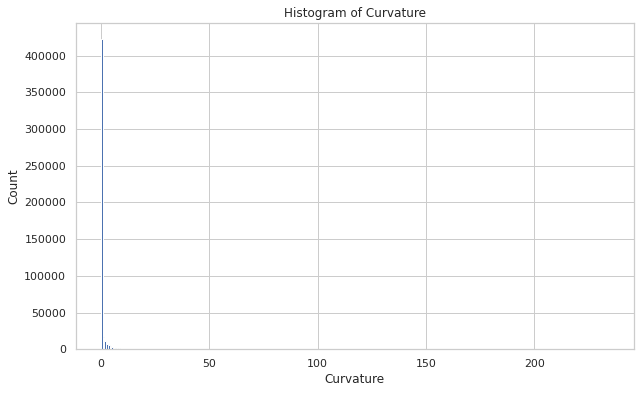

In [174]:
counts, bin_edges = np.histogram(curvatures, bins=300)
print("Counts: ", counts)
# Calculate the bin centers
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Plot the histogram
plt.figure(figsize=(10,6))
plt.bar(bin_centers, counts, width=(bin_edges[1] - bin_edges[0]))
plt.title('Histogram of Curvature')
plt.xlabel('Curvature')
plt.ylabel('Count')
plt.show()


In [175]:
print(curvatures[:20]) # print the first 10 curvatures
print(np.std(curvatures)) # print the standard deviation of curvatures


[0.00049502 0.0015425  0.00982895 0.09915949 0.00000024 0.000001
 0.00000003 0.00000003 0.00000005 0.00000015 0.00000105 0.00000047
 0.00000054 0.00000092 0.00000024 0.00000198 0.00000011 0.00000157
 0.00000136 0.00000085]
2.5564335557412754
